# Imports

In [1]:
!pip install -q keras_tuner

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Input, LSTM, GRU
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt

from keras.utils import to_categorical

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import seaborn as sns

checkpoint_dir = '/content/drive/MyDrive/maga/checkpoints'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [3]:
def mae_plot(plot_name, hist_df):
  sns.set_style("whitegrid")
  fig, ax = plt.subplots(figsize=(8, 5))
  ax = sns.lineplot(data=hist_df['mae'], label='Train MAE', color='lightblue')
  ax = sns.lineplot(data=hist_df['val_mae'], label='Valid. MAE', color='steelblue')
  ax.set_xlim(0, len(hist_df)-1)
  ax.set_title('График значения метрики MAE\nдля тренировочной и валидационной выборки', fontsize=12, fontweight='bold')
  ax.set_xlabel('Номер эпохи', fontsize=12)
  ax.set_ylabel('Значение метрики MAE', fontsize=12)
  if plot_name != None:
    fig.savefig('/content/drive/MyDrive/maga/pic/mae_plot/' + plot_name + '.png')

def save_load_history(history, history_dir, save_flag):
  if save_flag:
    hist_df = pd.DataFrame(history.history)
    with open('/content/drive/MyDrive/maga/history/history_' + history_dir, mode='w') as f:
      hist_df.to_csv(f)
  else:
    hist_df = pd.read_csv('/content/drive/MyDrive/maga/history/history_' + history_dir, sep=',', engine='python', index_col=0)
    return hist_df

# Read and split data

In [80]:
df = pd.read_csv('/content/drive/MyDrive/maga/dataset/dataset_mmpp.csv', sep=',', index_col=0)

In [173]:
X = df.iloc[:, 0:1500]
y = df.iloc[:, 1500:1610]
#y_k_value = y['k_list']

In [174]:
X_list = []

In [175]:
for i in range(1, X.shape[1]):
  X_list.append(X[str(i)] - X[str(i-1)])

In [176]:
X = pd.DataFrame(np.array(X_list).T.tolist())

In [177]:
X['k_list'] = df['k_list']

In [178]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,k_list
0,0.000071,0.000600,0.000004,0.000127,0.000449,0.000817,0.000072,0.000326,0.000240,0.000064,...,0.000282,0.000048,0.000195,0.000094,0.000212,0.000009,0.000002,0.000043,0.000282,6
1,0.000453,0.000139,0.001713,0.000485,0.002234,0.004646,0.001542,0.000062,0.001615,0.001706,...,0.000183,0.000466,0.000201,0.002633,0.001297,0.001387,0.001213,0.000025,0.002235,2
2,0.000176,0.000166,0.000025,0.000055,0.000023,0.000330,0.000010,0.000028,0.000074,0.000829,...,0.000184,0.000064,0.000033,0.000123,0.000137,0.000152,0.000119,0.000216,0.000044,9
3,0.000010,0.000011,0.000257,0.000264,0.000062,0.000017,0.000039,0.000102,0.000176,0.000060,...,0.000069,0.000146,0.000012,0.000049,0.000046,0.000058,0.000039,0.000213,0.000061,7
4,0.000065,0.000041,0.000067,0.000017,0.000162,0.000026,0.000091,0.000213,0.000032,0.000125,...,0.000306,0.000008,0.000178,0.000131,0.000142,0.000213,0.000240,0.000295,0.000140,9


In [179]:
X, y = np.array(X), np.array(y)

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [181]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 1500), (2000, 1500), (8000, 110), (2000, 110))

In [182]:
scaler = MinMaxScaler()

In [183]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Tune

In [18]:
from tensorflow.keras import regularizers

In [ ]:
def build_model(hp):
    dnn_layers_ss = [1,2,3,4,5]
    dnn_units_min, dnn_units_max = 32, 1024
    active_func_ss = ['relu', 'sigmoid', 'selu']
    optimizer_ss = ['adam']
    lr_min, lr_max = 1e-4, 1e-1
    dropout_value = [0.1, 0.2, 0.3, 0.4]

    active_func = hp.Choice('activation', active_func_ss)
    optimizer = hp.Choice('optimizer', optimizer_ss)
    lr = hp.Float('learning_rate', min_value=lr_min, max_value=lr_max, sampling='log')
    drop = hp.Choice('rate', dropout_value)

    inputs = Input(shape=(X_train.shape[1],))

    # create hidden layers
    dnn_units = hp.Int(f"0_units", min_value=dnn_units_min, max_value=dnn_units_max)
    dense = Dense(units=dnn_units, activation=active_func)(inputs)
    for layer_i in range(hp.Choice("n_layers", dnn_layers_ss) - 1):
        dnn_units = hp.Int(f"{layer_i}_units", min_value=dnn_units_min, max_value=dnn_units_max)
        dense = Dense(units=dnn_units, activation=active_func, kernel_regularizer=regularizers.l2(0.001))(dense)
        if hp.Boolean("dropout"):
          Dropout(rate=drop)(dense)
    outputs = Dense(units=110)(dense)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mse',
                  metrics='mae')
    return model
    #, kernel_regularizer=regularizers.l2(0.001)

# Tune Hyperband

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective='val_mae',
                     overwrite=True,
                     max_epochs=5,
                     factor=3,
                     directory='/content/drive/MyDrive/maga/tune',
                     project_name='recurr_reg_hyperband_1')

NameError: ignored

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

In [ ]:
tuner.search(
    X_train_scaled,
    y_train,
    epochs=5,
    validation_split=0.2,
    callbacks=[stop_early],
)

# Tune Bayesian

In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_mae',
    max_trials=30,
    overwrite=True,
    directory='/content/drive/MyDrive/maga/tune',
    project_name='mmpp_bayesian')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

In [ ]:
tuner.search(
    X_train_scaled,
    y_train_scaled,
    epochs=5,
    validation_split=0.2,
    callbacks=[stop_early],
)

Trial 30 Complete [00h 00m 22s]
val_mae: 0.16342082619667053

Best val_mae So Far: 0.11449343711137772
Total elapsed time: 00h 08m 02s


# Best model

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps.values

{'activation': 'relu',
 'optimizer': 'adam',
 'learning_rate': 0.0025672918934550766,
 'rate': 0.1,
 '0_units': 713,
 'n_layers': 2,
 'dropout': False,
 '1_units': 266,
 '2_units': 854,
 '3_units': 853}

In [ ]:
best_model = tuner.get_best_models()[0]

best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1500)]            0         
                                                                 
 dense (Dense)               (None, 713)               1070213   
                                                                 
 dense_1 (Dense)             (None, 713)               509082    
                                                                 
 dense_2 (Dense)             (None, 110)               78540     
                                                                 
Total params: 1,657,835
Trainable params: 1,657,835
Non-trainable params: 0
_________________________________________________________________


# My model

In [184]:
# Setup the layers
model = keras.Sequential(
  [
      Input(shape=(X_train.shape[1],)),
      Dense(units=713, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      Dropout(0.3),
      Dense(units=266, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      Dropout(0.3),
      Dense(units=854, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      Dropout(0.3),
      Dense(units=853, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      Dropout(0.3),
      Dense(110),
  ]
)

In [185]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 713)               1070213   
                                                                 
 dropout_16 (Dropout)        (None, 713)               0         
                                                                 
 dense_21 (Dense)            (None, 266)               189924    
                                                                 
 dropout_17 (Dropout)        (None, 266)               0         
                                                                 
 dense_22 (Dense)            (None, 854)               228018    
                                                                 
 dropout_18 (Dropout)        (None, 854)               0         
                                                                 
 dense_23 (Dense)            (None, 853)              

In [186]:
model.compile(optimizer=Adam(learning_rate=0.0025672918934550766),
                  loss='mse',
                  metrics='mae')

# Train model

In [ ]:
def myprint(s):
    with open('/content/drive/MyDrive/maga/model_summary/mmpp_reg_interval_bayesian_2layers.txt','a') as f:
        print(s, file=f)

best_model.summary(print_fn=myprint)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/maga/checkpoints/mmpp'
checkpoint_name = '/mmpp_reg_interval_bayesian_3layers'

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir + checkpoint_name,
                                                 monitor='val_mae',
                                                 save_weights_only=False,
                                                 verbose=1)

In [187]:
#model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, validation_split=0.2, shuffle=True)
#, callbacks=[cp_callback]

Epoch 1/50
200/200 [==============================] - 11s 45ms/step - loss: 0.1949 - mae: 0.1666 - val_loss: 0.0450 - val_mae: 0.1304
Epoch 2/50
200/200 [==============================] - 11s 54ms/step - loss: 0.0465 - mae: 0.1346 - val_loss: 0.0419 - val_mae: 0.1270
Epoch 3/50
200/200 [==============================] - 11s 55ms/step - loss: 0.0481 - mae: 0.1325 - val_loss: 0.0420 - val_mae: 0.1315
Epoch 4/50
200/200 [==============================] - 10s 51ms/step - loss: 0.0491 - mae: 0.1312 - val_loss: 0.0406 - val_mae: 0.1172
Epoch 5/50
200/200 [==============================] - 10s 50ms/step - loss: 0.0427 - mae: 0.1273 - val_loss: 0.0392 - val_mae: 0.1154
Epoch 6/50
200/200 [==============================] - 11s 56ms/step - loss: 0.0422 - mae: 0.1264 - val_loss: 0.0393 - val_mae: 0.1152
Epoch 7/50
200/200 [==============================] - 12s 58ms/step - loss: 0.0440 - mae: 0.1260 - val_loss: 0.0397 - val_mae: 0.1156
Epoch 8/50
200/200 [==============================] - 10s 48ms

In [18]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/maga/checkpoints/mmpp/mmpp_reg_interval_bayesian_3layers')

In [188]:
y_pred = model.predict(X_test_scaled)

63/63 [==============================] - 1s 10ms/step


In [189]:
y_pred = scaler.inverse_transform(y_pred)

In [190]:
hist_df = pd.DataFrame(history.history)

In [191]:
save_load_history(history, 'mmpp_reg_interval_bayesian_3layers_50epoch_вdr03', True)

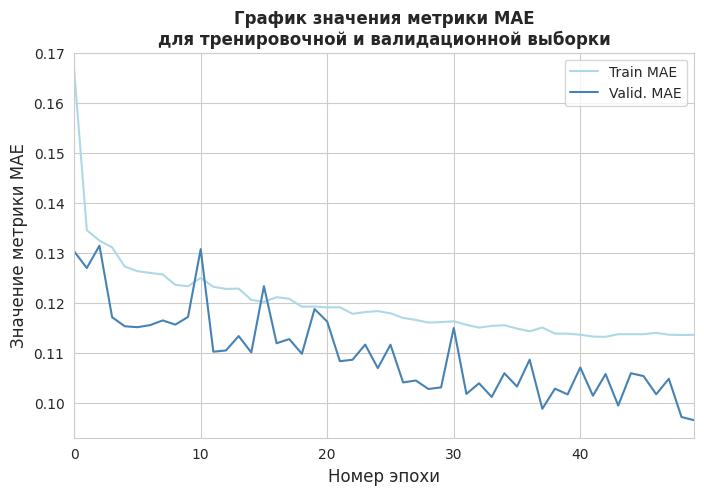

In [192]:
#'recurr_reg_interval_bayesian_5layers_150epochs_15000_33_32'
mae_plot('mmpp_reg_interval_bayesian_3layers_50epoch_dr03', hist_df)

# Compare curve

In [193]:
import random
import time

In [194]:
k_list = np.asarray(pd.DataFrame(X_test).iloc[:, 1499:]).reshape(-1)

In [195]:
k_list

array([6., 3., 7., ..., 5., 7., 6.])

In [196]:
X = df.iloc[:, 0:1500]
y = df.iloc[:, 1500:1610]

In [197]:
X, y = np.array(X), np.array(y)

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [199]:
def sum_diag_matrix(matrix, matrix_size):
  for i in range(matrix_size):
    for j in range(matrix_size):
      if i==j:
        matrix[i][j] = -(sum(matrix[i]) - matrix[i][j])
  return matrix

def calculation_pi(q_matrix_for_solve, matrix_size):
    v = np.zeros(matrix_size)
    v[-1] = 1
    pi = np.linalg.solve(q_matrix_for_solve, v)
    return pi

def choose_time_work(pi, T, K,k):
    p = 0
    rnd = random.random()

    for i in range (len(pi)):
      if rnd >= (p +pi[i]):
        p += pi[i]
      else:
        k = i
    rnd_list = []
    for v in range(K):
        if v != k:
            rnd = random.expovariate(q_matrix[k][v])
            rnd_list.append(rnd)
        if v == k:
            rnd = 10e100
            rnd_list.append(rnd)
    temp = min(rnd_list)
    k = rnd_list.index(min(rnd_list))
    T += temp
    return k, T

def cycle(T, k, s, t0, time_list):
    while s < S:
        thau = random.expovariate(lmbd_matrix[k])
        if t0 + thau < T:
            t0 += thau
            s += 1
            time_list.append(t0)
        else:
            return s, T, time_list
    return s, T, time_list

In [202]:
t_time = []
timeout_list = []
for i in range(X_test.shape[0]):
  print('i', i)
  test_list = y_pred[i, : int(k_list[i]) ** 2]

  l = 0
  q_matrix = []
  for idx in range(0, int(k_list[i])):
    sub = []
    for jdx in range(0, int(k_list[i])):
        sub.append(test_list[l])
        l += 1
    q_matrix.append(sub)

  q_matrix = sum_diag_matrix(q_matrix, int(k_list[i]))

  q_matrix_for_solve = q_matrix.copy()
  q_matrix_for_solve[int(k_list[i])-1] = np.ones(int(k_list[i]))

  pi = calculation_pi(q_matrix_for_solve, int(k_list[i]))

  lmbd_matrix = y_pred[i, 100:100 + int(k_list[i])]

  log_item = 0
  p = 0
  K = int(k_list[i])
  v = 0
  S = X_test.shape[1]
  T = 0
  s = 0
  t0 = 0
  time_list=[]

  k = 0
  timeout = time.time() + 1
  while s < S:
    k, T = choose_time_work(pi, T, K, k)
    s, t0, time_list = cycle(T, k, s, t0, time_list)
    if time.time() > timeout:
      print('timeout', i)
      timeout_list.append(i)
      break


  t_time.append(time_list)

i 0
timeout 0
i 1
i 2
timeout 2
i 3
timeout 3
i 4
timeout 4
i 5
timeout 5
i 6
timeout 6
i 7
i 8
timeout 8
i 9
timeout 9
i 10
i 11
i 12
timeout 12
i 13
i 14
timeout 14
i 15
timeout 15
i 16
i 17
i 18
timeout 18
i 19
timeout 19
i 20
timeout 20
i 21
timeout 21
i 22
timeout 22
i 23
timeout 23
i 24
i 25
timeout 25
i 26
timeout 26
i 27
i 28
timeout 28
i 29
timeout 29
i 30
timeout 30
i 31
i 32
i 33
i 34
timeout 34
i 35
timeout 35
i 36
timeout 36
i 37
timeout 37
i 38
i 39
timeout 39
i 40
timeout 40
i 41
timeout 41
i 42
timeout 42
i 43
timeout 43
i 44
timeout 44
i 45
i 46
timeout 46
i 47
timeout 47
i 48
timeout 48
i 49
timeout 49
i 50
timeout 50
i 51
i 52
timeout 52
i 53
timeout 53
i 54
timeout 54
i 55
i 56
timeout 56
i 57
timeout 57
i 58
i 59
timeout 59
i 60
timeout 60
i 61
timeout 61
i 62
timeout 62
i 63
i 64
timeout 64
i 65
timeout 65
i 66
i 67
timeout 67
i 68
timeout 68
i 69
i 70
timeout 70
i 71
timeout 71
i 72
timeout 72
i 73
timeout 73
i 74
i 75
timeout 75
i 76
i 77
i 78
timeout 78
i 79
ti

In [203]:
len(timeout_list)

1357

In [204]:
df_prov = pd.DataFrame(t_time)

In [205]:
df_prov = df_prov.drop(timeout_list)

In [206]:
X_test = pd.DataFrame(X_test)

In [207]:
X_test = X_test.drop(timeout_list)

In [208]:
def print_curve_metrics(size, X_test_interval, df_prov_interval, itog_itog_list, csv_name):
  relative_error_mean_list = []
  relative_error_std_list = []
  for i in range(size):
    relative_error_mean_list.append(abs(X_test_interval.iloc[i].mean() - df_prov_interval.iloc[i].mean()) / X_test_interval.iloc[i].mean())
    relative_error_std_list.append(abs(X_test_interval.iloc[i].std() - df_prov_interval.iloc[i].std()) / X_test_interval.iloc[i].std())

  abs_list = []
  abs_itog_list = itog_itog_list
  for i in range(size):
    for j in range(X_test.shape[1]):
      abs_itog_list[i][j] = abs(itog_itog_list[i][j])
    abs_list.append(max(itog_itog_list[i]))

  test_results = {}
  test_results['relative_error_mean'] = relative_error_mean_list
  test_results['relative_error_std'] = relative_error_std_list
  test_results['abs_list'] = abs_list

  metrics_df = pd.DataFrame(test_results)

  test_result_mean = {}
  test_result_mean['relative_error_mean_mean'] = metrics_df['relative_error_mean'].mean()
  test_result_mean['relative_error_mean_median'] = metrics_df['relative_error_mean'].median()
  test_result_mean['relative_error_std_mean'] = metrics_df['relative_error_std'].mean()
  test_result_mean['relative_error_std_median'] = metrics_df['relative_error_std'].median()
  test_result_mean['abs_mean'] = metrics_df['abs_list'].mean()
  test_result_mean['abs_median'] = metrics_df['abs_list'].median()

  metrics_mean_df = pd.DataFrame([test_result_mean])

  print(metrics_mean_df)

  if csv_name != None:
    metrics_df.to_csv('/content/drive/MyDrive/maga/metrics/mmpp/curve_interval_metrics_' + csv_name + '.csv')
    metrics_mean_df.to_csv('/content/drive/MyDrive/maga/metrics/mmpp/curve_interval_mean_metrics_' + csv_name + '.csv')


In [209]:
df_prov_list = []

In [210]:
for i in range(1, df_prov.shape[1]):
  df_prov_list.append(df_prov[i] - df_prov[i-1])

In [211]:
df_prov_interval = pd.DataFrame(np.array(df_prov_list).T.tolist())

In [212]:
X_test_interval = pd.DataFrame(X_test)

In [213]:
def draw_curve(x_value, pic_value, X_test, df_prov):
  y = range(0, x_value)

  for i in range(pic_value):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(4, 3))
    ax = sns.lineplot(x = X_test.iloc[i, :x_value], y=y, drawstyle='steps-pre', label='Истинная')
    ax = sns.lineplot(x = np.array(df_prov.iloc[i:i+1, :x_value])[0], y=y, drawstyle='steps-pre', label='Оцененная')
    ax.legend(loc = 4)
    ax.set_xlim(0, max(max(X_test.iloc[i, :x_value]), max(np.array(df_prov.iloc[i:i+1, :x_value])[0])))
    ax.set_ylim((0, x_value))
    #ax.set_title('Сравнение истинной и оценной кривой', fontsize=12, fontweight='bold')
    ax.set_xlabel('Время', fontsize=12)
    ax.set_ylabel('Шаг', fontsize=12);

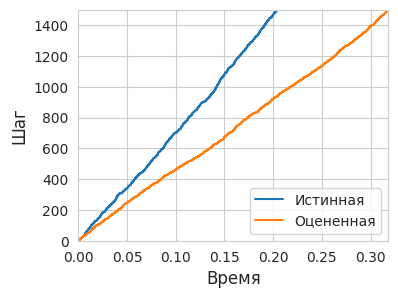

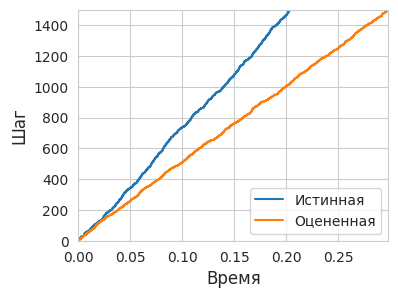

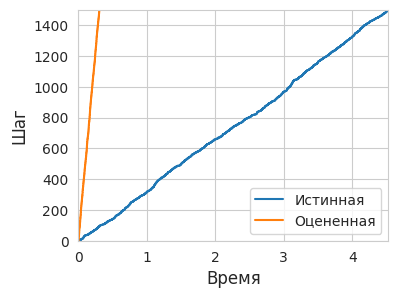

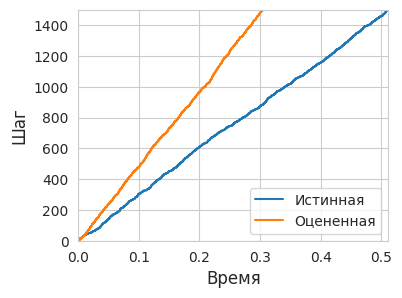

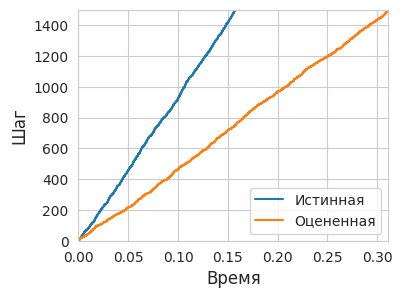

In [214]:
draw_curve(X_test.shape[1], 5, X_test, df_prov)

In [215]:
a = np.array(X_test.iloc[0:X_test.shape[0], :X_test.shape[1]])
b = np.array(df_prov.iloc[0:X_test.shape[0], :X_test.shape[1]])

In [216]:
itog_itog_list = []

for i in range(X_test.shape[0]):
  counter1 = 0
  counter2 = 0
  itog_list = []

  if max(a[i]) > max(b[i]):
    while counter2 < X_test.shape[1]:
      if a[i][counter1] < b[i][counter2]:
        counter1 += 1
        itog_list.append(abs(counter1 - counter2))
      elif a[i][counter1] > b[i][counter2]:
        counter2 += 1
        itog_list.append(abs(counter1 - counter2))
      else:
        counter1 += 1
        counter2 += 1
        itog_list.append(abs(counter1 - counter2))
    itog_itog_list.append(itog_list)
  else:
    while counter1 < X_test.shape[1]:
      if a[i][counter1] < b[i][counter2]:
        counter1 += 1
        itog_list.append(abs(counter1 - counter2))
      elif a[i][counter1] > b[i][counter2]:
        counter2 += 1
        itog_list.append(abs(counter1 - counter2))
      else:
        counter1 += 1
        counter2 += 1
        itog_list.append(abs(counter1 - counter2))
    itog_itog_list.append(itog_list)

In [217]:
def print_curve_metrics(size, X_test_interval, df_prov_interval, itog_itog_list, csv_name):
  relative_error_mean_list = []
  relative_error_std_list = []
  for i in range(size):
    relative_error_mean_list.append(abs(X_test_interval.iloc[i].mean() - df_prov_interval.iloc[i].mean()) / X_test_interval.iloc[i].mean())
    relative_error_std_list.append(abs(X_test_interval.iloc[i].std() - df_prov_interval.iloc[i].std()) / X_test_interval.iloc[i].std())

  abs_list = []
  abs_itog_list = itog_itog_list
  for i in range(size):
    for j in range(X_test.shape[1]):
      abs_itog_list[i][j] = abs(itog_itog_list[i][j])
    abs_list.append(max(itog_itog_list[i]))

  test_results = {}
  test_results['relative_error_mean'] = relative_error_mean_list
  test_results['abs_list'] = abs_list

  metrics_df = pd.DataFrame(test_results)

  test_result_mean = {}
  test_result_mean['relative_error_mean_mean'] = metrics_df['relative_error_mean'].mean()
  test_result_mean['relative_error_mean_median'] = metrics_df['relative_error_mean'].median()
  test_result_mean['abs_mean'] = metrics_df['abs_list'].mean()
  test_result_mean['abs_median'] = metrics_df['abs_list'].median()

  metrics_mean_df = pd.DataFrame([test_result_mean])

  print(metrics_mean_df)

  if csv_name != None:
    metrics_df.to_csv('/content/drive/MyDrive/maga/metrics/mmpp/curve_interval_metrics_' + csv_name + '.csv')
    metrics_mean_df.to_csv('/content/drive/MyDrive/maga/metrics/mmpp/curve_interval_mean_metrics_' + csv_name + '.csv')


In [218]:
len(itog_itog_list)

643

In [219]:
print_curve_metrics(X_test.shape[0], X_test_interval, df_prov_interval, itog_itog_list, 'mmpp_reg_interval_bayesian_3layers_50epoch_dr03')

   relative_error_mean_mean  relative_error_mean_median    abs_mean  \
0                  0.998736                    0.998715  476.435459   

   abs_median  
0       379.0  


In [106]:
print_curve_metrics(X_test.shape[0], X_test_interval, df_prov_interval, itog_itog_list, 'mmpp_reg_interval_bayesian_3layers_100epochs_1500')

   relative_error_mean_mean  relative_error_mean_median  \
0                  0.998965                    0.998963   

   relative_error_std_mean  relative_error_std_median  abs_mean  abs_median  
0                 0.998205                   0.998205  350.9618       338.0  
